In [1]:
%run -i model.ipynb

100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


# GANS

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
device = torch.device("cuda", 0)

In [3]:
import numpy as np
NOISE_DIM = 4
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=1):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100, input_param=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x, params):
        #x = torch.cat([x, params.repeat(x.shape[0], 1)], dim=1)
        x = torch.cat([x, params], dim=1)
        h1 = torch.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = torch.sigmoid(self.fc4(h3))
        return score

In [6]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
discriminator = Discriminator(in_dim = 1).to(device)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [7]:
################################
# IMPLEMENT HERE
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement GAN game

#d_loss(discriminator(data_gen), discriminator(inp_data))
#g_loss(discriminator(data_gen))
def g_loss(discrim_output):
    eps = 1e-10
    if TASK == 1: 
        loss = torch.log(1 - discrim_output + eps).mean()    
    elif TASK == 2:
        loss = - torch.log(discrim_output + eps).mean()
    elif TASK in (3, 4):
        loss = - discrim_output.mean()
    return loss


def d_loss(discrim_output_gen, discrim_output_real):
    eps = 1e-10
    if TASK in (1, 2): 
        loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
    elif TASK in (3, 4):
        loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
    return loss
################################

In [8]:
num_epochs = 20
batch_size = 32 # initially was 64
TASK = 2

In [9]:
from tqdm import trange

In [10]:
#data = torch.stack([y_sample() for _ in range(100000)]).reshape(-1,1)
#data = torch.Tensor([y_sample().item() for _ in range(100000)]).reshape(-1,1)
fixed_noise = torch.Tensor(sample_noise(10000)).to(device)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in trange(0, X.shape[0], batchsize):
        end = min(start + batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

In [11]:
def generate_data(n_samples, mu_range=(-5, 5)):
    mus = ((mu_range[0] - mu_range[1]) * (torch.rand(n_samples)) + mu_range[1]).to(device)
    with pyro.condition(data={"mu": mus}):
        data = y_sample().detach().to(device)
    return data.reshape(-1,1), mus.reshape(-1,1)

data, mus = generate_data(10000, mu_range=(-5, 5))

In [12]:
from IPython import display
def run_training():
    #plt.xlim(lims)
    #plt.ylim(lims)

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    k_d, k_g = 4, 1

    dis_loss, gen_loss = [], []

    try:
        for epoch in range(num_epochs):
            dis_epoch_loss = []
            gen_epoch_loss = []
                        
            for input_data, input_mu in iterate_minibatches(data, batch_size, y=mus):
                # Optimize D
                for _ in range(k_d):
                    # Sample noise
                    noise = torch.Tensor(sample_noise(len(input_data))).to(device)

                    # Do an update
                    inp_data = input_data.to(device)
                    data_gen = generator(noise, input_mu)

                    loss = d_loss(discriminator(data_gen, input_mu), discriminator(inp_data, input_mu))
                    if TASK == 4:
                        grad_penalty = calc_gradient_penalty(data_gen.data, inp_data.data)
                        loss += grad_penalty
                        
                    d_optimizer.zero_grad()
                    loss.backward()
                    d_optimizer.step()

                    if TASK == 3:                    
                        for p in discriminator.parameters():
                            p.data.clamp_(clamp_lower, clamp_upper)
                dis_epoch_loss.append(loss.item())

                # Optimize G
                for _ in range(k_g):
                    # Sample noise
                    noise = torch.Tensor(sample_noise(len(input_data))).to(device)

                    # Do an update
                    data_gen = generator(noise, input_mu)
                    loss = g_loss(discriminator(data_gen, input_mu))
                    g_optimizer.zero_grad()
                    loss.backward()
                    g_optimizer.step()
                gen_epoch_loss.append(loss.item())
            dis_loss.append(np.mean(dis_epoch_loss))
            gen_loss.append(np.mean(gen_epoch_loss))
            # Visualize
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            ax1.set_title("Epoch {}".format(epoch))
            ax1.hist(data.detach().cpu().numpy(), bins=100, normed=True, label='true');
            ax1.hist(generator(fixed_noise, mus).detach().cpu().numpy(),
                     bins=100, color='g', normed=True, alpha=0.5, label='gan');
            ax1.grid()
            ax1.legend()
            
            ax2.plot(dis_loss, label='d_loss', c='b')
            ax2.set_title("epoch")
            ax2.set_title("loss")
            ax2.grid()
            ax2.legend()
            
            ax3 = ax2.twinx()
            ax3.plot(gen_loss, label='g_loss', c='r')
            ax3.grid()
            ax3.legend()
            
            
            display.clear_output(wait=True)
            plt.show()


    except KeyboardInterrupt:
        pass

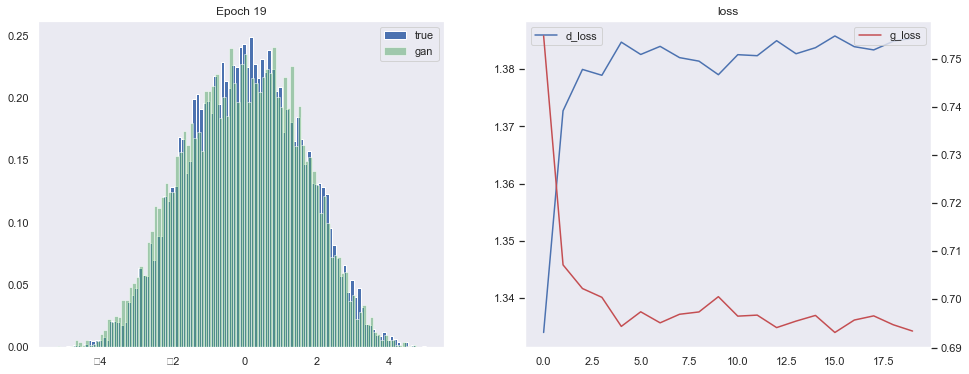

In [13]:
run_training()

#  Conditional GAN simple results

In [14]:
input_mu = torch.stack(10000 * [-10 * torch.rand(1) + 5]).view(-1, 1).to(device)

with pyro.condition(data={"mu": input_mu}):
    data = y_sample().detach().to(device)

In [15]:
print(input_mu[0], f(input_mu[0]))

tensor([1.7683], device='cuda:0') tensor([1.9240], device='cuda:0')


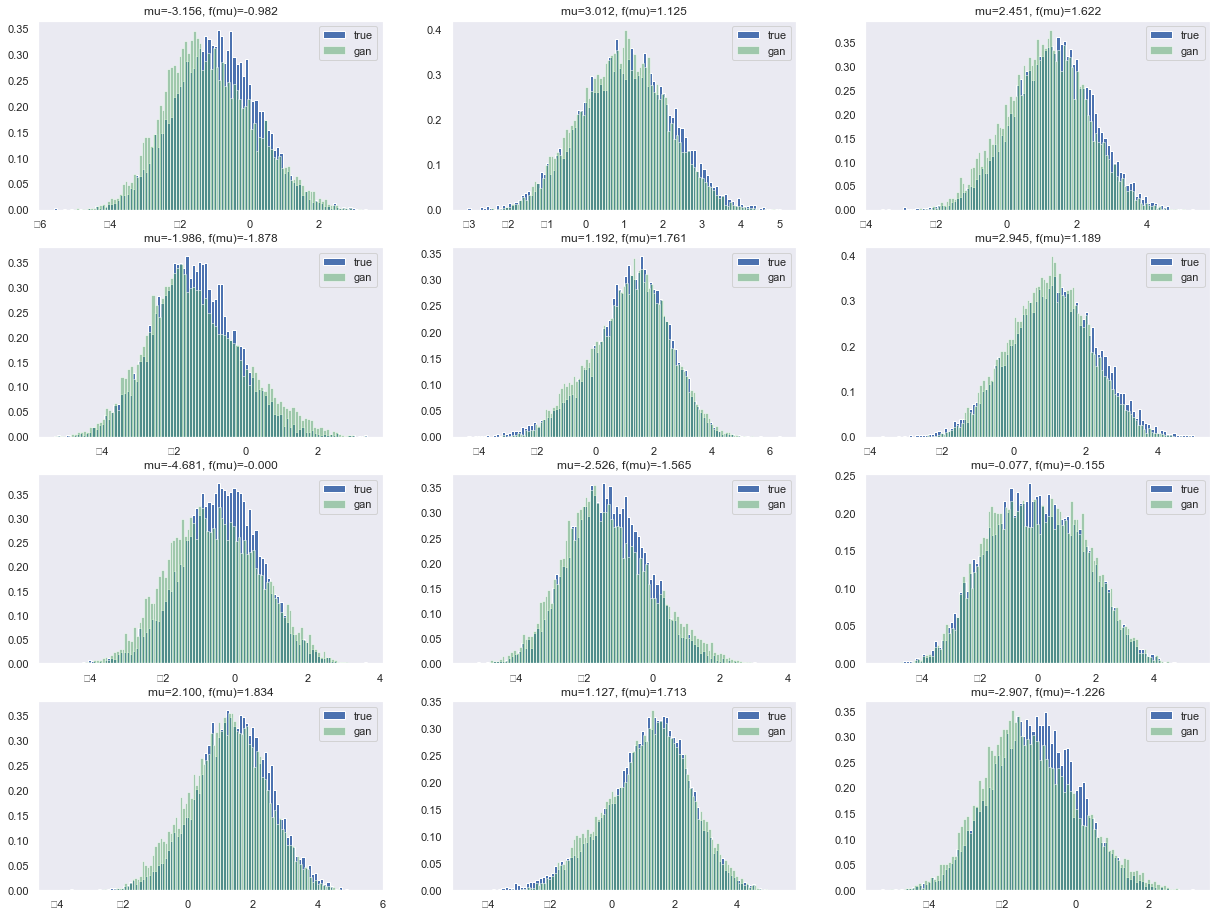

In [16]:
plt.figure(figsize=(21,16))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        input_mu = torch.stack(10000 * [-10 * torch.rand(1) + 5]).view(-1, 1).to(device)

        with pyro.condition(data={"mu": input_mu}):
            data = y_sample().detach().to(device)         

        plt.hist(data.detach().cpu().numpy(), bins=100, density=True, label='true');
        plt.hist(generator(fixed_noise, input_mu).detach().cpu().numpy(),
                 bins=100, color='g', density=True, alpha=0.5, label='gan');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}, f(mu)={:.3f}".format(input_mu[0].item(), f(input_mu[0]).item()))

# Test on mu outside of training domain

/root/miniconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'mu=15.000, f(mu)=1.650')

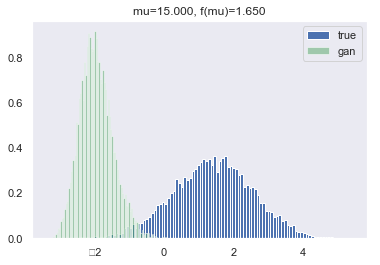

In [17]:
input_mu = torch.full(size=(10000, ), fill_value=15.).to(device)

with pyro.condition(data={"mu": input_mu}):
    data = y_sample().detach().to(device)   
            
plt.hist(data.detach().cpu().numpy(), bins=100, normed=True, label='true');
plt.hist(generator(fixed_noise, input_mu.view(-1, 1)).detach().cpu().numpy(),
     bins=100, color='g', density=True, alpha=0.5, label='gan');
plt.grid()
plt.legend()
plt.title("mu={:.3f}, f(mu)={:.3f}".format(input_mu[0].item(), f(input_mu[0]).item()))

In [18]:
for mu_val in np.arange(-4,4, 0.5):
    input_mu = torch.full(size=(10000, ), fill_value=mu_val)

    with pyro.condition(data={"mu": input_mu}):
        data = y_sample().detach().to(device)   
    print(mu.item(), R(data))

100.0 tensor(21.5024, device='cuda:0')
100.0 tensor(19.2806, device='cuda:0')
100.0 tensor(16.9582, device='cuda:0')
100.0 tensor(14.9278, device='cuda:0')
100.0 tensor(14.1935, device='cuda:0')
100.0 tensor(14.8889, device='cuda:0')
100.0 tensor(17.6514, device='cuda:0')
100.0 tensor(22.2184, device='cuda:0')
100.0 tensor(27.9420, device='cuda:0')
100.0 tensor(33.9966, device='cuda:0')
100.0 tensor(38.5650, device='cuda:0')
100.0 tensor(42.0979, device='cuda:0')
100.0 tensor(42.3850, device='cuda:0')
100.0 tensor(41.1100, device='cuda:0')
100.0 tensor(38.2530, device='cuda:0')
100.0 tensor(34.5287, device='cuda:0')


In [19]:
from copy import deepcopy

In [20]:
class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
        
    def forward(self, noise, mu):
        
        return self.gen(noise, mu)

In [21]:
io_model = InputOptimisation(generator)

lr = 0.1
# io_optimizer = optim.Adam(io_model.parameters(), lr=lr)

sample_size = 1000

In [28]:
mu_optim = torch.tensor(0.)

mu_optim = mu_optim.reshape(-1, 1).repeat(sample_size, 1).to(device)
mu_optim.requires_grad=True

In [29]:
%%time
n_iter = 10000
losses = []
m_vals = []
for _iter in range(n_iter):    
    noise = torch.Tensor(sample_noise(sample_size)).to(device)
    #print(mu_optim[:2, 0])
    # Do an update
    data_gen = io_model(noise, mu_optim)
    loss = R(data_gen)
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0, 0].item())

CPU times: user 16.4 s, sys: 2.69 s, total: 19.1 s
Wall time: 18.8 s


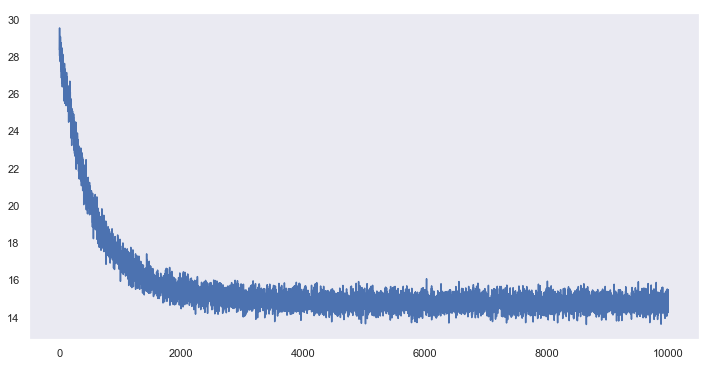

In [30]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()

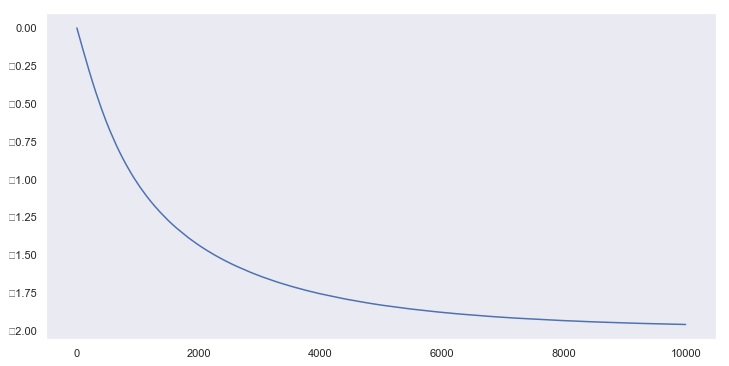

In [33]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()

In [31]:
np.min(losses)

13.629891395568848

In [32]:
mu_optim

tensor([[-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.9554],
        [-1.

In [27]:
input_mu = torch.full(size=(10000, ), fill_value=-6.6575)

with pyro.condition(data={"mu": input_mu}):
    data = y_sample().detach().to(device)   
print(mu.item(), R(data))

100.0 tensor(15.7646, device='cuda:0')
